# Modelling LSTM with Scaled Data

## Load Dataset

In [1]:
import pandas as pd
df = pd.read_csv('../data/precio_mercado_diario.csv', parse_dates=['datetime_utc'], index_col=0)
df = df.loc["2020":].copy()
df

,Mercado SPOT
datetime_utc,
2020-01-01 00:00:00+00:00,38.60
2020-01-01 01:00:00+00:00,36.55
...,...
2023-08-04 20:00:00+00:00,94.00
2023-08-04 21:00:00+00:00,91.70


## Data Preprocessing

### Scale Data

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(df)

### Train Test Split

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_norm, test_size=0.2, shuffle=False)

### Create Sequences

In [4]:
import numpy as np

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24 # Use 24 hours prior to predict the following hour
X_train, y_train = create_sequences(train, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)

## Modelling

### Design NN Architecture

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

model = Sequential(layers=[
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/keras/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Train Model

In [6]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train, y_train, epochs=50, batch_size=64, verbose=0,
    validation_data=(X_test, y_test), callbacks=[early_stop])

### Calculate Predictions

In [7]:
y_pred = model.predict(X_test)
y_pred


  1/197 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step


 57/197 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


116/197 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


173/197 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[0.17380626],
       [0.1386231 ],
       [0.12192503],
       ...,
       [0.13104069],
       [0.13494721],
       [0.13034955]], dtype=float32)

### Evaluate Model

In [8]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred, squared=False)

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.015593511489771601

### Comparison: Real Data & Prediction

#### Descale Data

In [9]:
y_pred_scaled_inverse = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y_test)

#### Create DataFrame

In [10]:
import sys
sys.path.append('../')

In [11]:
import utils

dic_pred = {
    'y_pred': y_pred,
    'y_pred_scaled_inverse': y_pred_scaled_inverse,
}

df_pred = utils.process_df_pred(df, y_test, dic_pred)
df_pred

/Users/sota/Library/CloudStorage/Dropbox/2 Business/1 Datons/2 Areas/Courses/22 TS/solutions-new/notebooks/60_Forecasting II Deep Learning/4_Data Scaling/../utils.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=date_start, end=date_end, freq='H')


,y_true,y_pred,y_pred_scaled_inverse
2022-11-15 22:00:00+00:00,0.150000,0.173806,121.664383
2022-11-15 23:00:00+00:00,0.129314,0.138623,97.036171
...,...,...,...
2023-08-04 20:00:00+00:00,0.134286,0.134947,94.463051
2023-08-04 21:00:00+00:00,0.131000,0.130350,91.244682


#### Evaluate Model

In [12]:
mean_squared_error(df_pred.y_true, df_pred.y_pred_scaled_inverse, squared=False)

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


101.26353773719516

#### Visualize Data

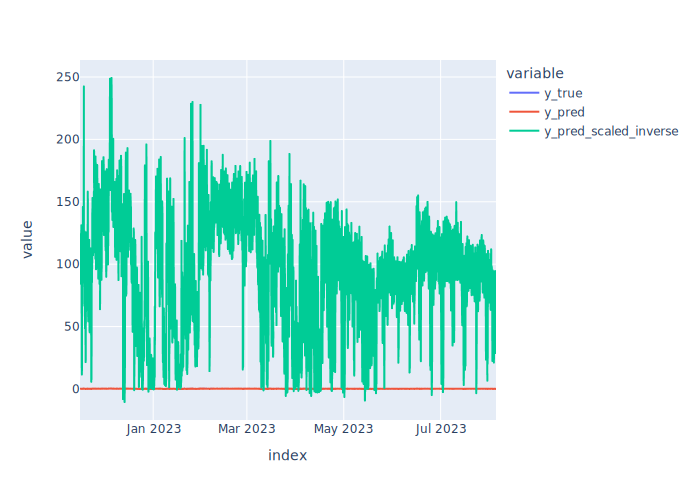

In [13]:
utils.plot_df(df_pred)